In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.metrics import RocCurveDisplay
import catboost as cb
from sklearn.metrics import roc_auc_score

# 1. Читаем данные и смотрим на них.

GA Sessions   
Одна строка = один визит на сайт.  
Описание атрибутов:  
~ session_id — ID визита;  
~ client_id — ID посетителя;  
~ visit_date — дата визита;  
~ visit_time — время визита;  
~ visit_number — порядковый номер визита клиента;  
~ utm_source — канал привлечения;  
~ utm_medium — тип привлечения;  
~ utm_campaign — рекламная кампания;  
~ utm_keyword — ключевое слово;  
~ device_category — тип устройства;  
~ device_os — ОС устройства;  
~ device_brand — марка устройства;  
~ device_model — модель устройства;  
~ device_screen_resolution — разрешение экрана;  
~ device_browser — браузер;  
~ eo_country — страна;  
~ geo_city — город.  
  
GA Hits  
Одна строка = одно событие в рамках одного визита на сайт.  
Описание атрибутов:  
~ session_id — ID визита;  
~ hit_date — дата события;  
~ hit_time — время события;  
~ hit_number — порядковый номер события в рамках сессии;  
~ hit_type — тип события;  
~ hit_referer — источник события;  
~ hit_page_path — страница события;  
~ event_category — тип действия;  
~ event_action — действие;  
~ event_label — тег действия;  
~ event_value — значение результата действия.  

In [2]:
gah = pd.read_csv('ga_hits.csv', low_memory=False)
gas = pd.read_csv('ga_sessions.csv', low_memory=False)

In [3]:
print(gah.shape)
print(gas.shape)

(15726470, 11)
(1860042, 18)


In [4]:
gah.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [5]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


In [6]:
print('gah: ')
display(gah.head(3))
print('gas: ')
display(gas.head(3))

gah: 


,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN


gas: 


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk


От нас требуется построить модель предсказывающую факт совершения целевого действия (какого-то/каких-то gah.event_action).  
Но не говорится что считать целевым действием.  
Посмотрим какие бывают gah.event_action.

In [7]:
print('Всего уникальных gah.event_action: ', gah['event_action'].nunique())
print('')
display(gah['event_action'].value_counts())
# запишем уникальные event_action и их количество в csv файл для удобства анализа:
counts = gah['event_action'].value_counts()
counts_df = counts.reset_index()
counts_df.columns = ['event_action', 'count']
counts_df.to_csv('gah_event_actions.csv', index=False)

Всего уникальных gah.event_action:  230



event_action
view_card                     3558985
view_new_card                 3551009
sub_landing                   1798117
go_to_car_card                 973666
sub_view_cars_click            791515
                               ...   
click_on_android                    1
new_year_road_help_btn              1
titul_page_view                     1
show_pos_status_declined            1
survey_buy_after_sell_when          1
Name: count, Length: 230, dtype: int64

In [8]:
# Еще немного информации о разнообразии данных:
print('gah nunique: ')
display(gah.nunique())
print('gas nunique: ')
display(gas.nunique())

gah nunique: 


session_id        1734610
hit_date              226
hit_time           925887
hit_number            500
hit_type                1
hit_referer         37873
hit_page_path      342715
event_category         52
event_action          230
event_label         39825
event_value             0
dtype: int64

gas nunique: 


session_id                  1860042
client_id                   1391719
visit_date                      226
visit_time                    85318
visit_number                    537
utm_source                      293
utm_medium                       56
utm_campaign                    412
utm_adcontent                   286
utm_keyword                    1219
device_category                   3
device_os                        13
device_brand                    205
device_model                    104
device_screen_resolution       5039
device_browser                   57
geo_country                     166
geo_city                       2548
dtype: int64

Как-то нужно выбрать что мы будем считать целевым действием !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [9]:
# поле event_category по-моему не очень помогает
# тем более есть записи с одинаковыми event_action и разными event_category
pairs = gah[['event_action', 'event_category']]
unique_pairs = pairs.drop_duplicates()
sorted_unique_pairs = unique_pairs.sort_values(by='event_category')
print('Общее количество уникальных пар: ', len(sorted_unique_pairs))
sorted_unique_pairs.to_csv('gah_event_actions_category.csv', index=False)

Общее количество уникальных пар:  245


In [10]:
# вопрос открытый, пока просто возьмём какие-нибудь для тестирования
# для тестирования возьмём эти действия
target_actions = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click', 
          'sub_custom_question_submit_click', 'sub_call_number_click', 'sub_callback_submit_click', 
          'sub_submit_success', 'sub_car_request_submit_click']

Дальше при построении модели можно придерживаться двум подходам:  
 a. Из таблицы gah берём только факт совершения целевого действия.  
 b. Анализируем gah. Например, можно использовать RNN, в которую передавать последовательность действий пользователя в рамках одной сессии. И получать от неё вероятность совершения целевого действия в рамках этой сессии. Эту можель можно использовать как самостоятельную или в ансамбле. Мне нравится идея добавить эту вероятность в качестве нового параметра для модели из п.a. Правда, если вспомнить постановку задачи "Эта модель поможет: Оценивать эффективность каналов привлечения трафика; Адаптировать рекламные кампании; Улучшать UX сайта за счет анализа поведения пользователей.", то смысла в этом нет. Может быть можно было бы попробовать визуализировать пути в сессиях к целевому действию на "графе" по hit_page_path или hit_referer.  
Дальше после EDA пока будет реализован только п. a.

# 2. EDA

Типизируем данные, поработаем с пропусками, удалим дубли, сформируем новые признаки, построим матрицу корреляций и т.д.

In [11]:
# Ищем дубли 
print('Количестов дублей в gah: ', gah.duplicated().sum())
print('Количестов дублей в gas: ', gas.duplicated().sum())

Количестов дублей в gah:  0
Количестов дублей в gas:  0


In [12]:
# добавим в gas колонку-признак выполнения целевого действия в сессии (0 - не было совершено, 1 - совершено):
gah_target = gah[gah['event_action'].isin(target_actions)]
gas['target'] = gas['session_id'].isin(gah_target['session_id']).astype(int)

In [13]:
# видим сильную разбалансировку классов
gas['target'].value_counts()

target
0    1809728
1      50314
Name: count, dtype: int64

In [14]:
# удалим заведомо неинформативные колонки session_id и client_id
gas = gas.drop(columns=['session_id', 'client_id'])

In [15]:
# Посмотрим на пропуски (напомню, что всего 1860042 записи)
gas.isna().sum()

visit_date                        0
visit_time                        0
visit_number                      0
utm_source                       97
utm_medium                        0
utm_campaign                 219603
utm_adcontent                335615
utm_keyword                 1082061
device_category                   0
device_os                   1070138
device_brand                 367178
device_model                1843704
device_screen_resolution          0
device_browser                    0
geo_country                       0
geo_city                          0
target                            0
dtype: int64

In [16]:
# Пропуски есть только в столбцах с категориальными данными, поэтому заполним их значениями '(not set)' (такие же значения есть в geo_city)
columns_to_exclude = ['visit_date', 'visit_time', 'visit_number', 'target'] # список столбцов, которые нужно оставить без изменений
columns_to_convert = [col for col in gas.columns if col not in columns_to_exclude] # список столбцов, которые нужно преобразовать
for col in columns_to_convert:
    # Заполняем пропуски значением '(not set)'
    gas[col] = gas[col].fillna('(not set)')

In [17]:
# объединим visit_date и visit_time и приведём к типу datetime, колонку visit_time после этого удалим
gas['visit_date'] = pd.to_datetime(gas['visit_date'] + ' ' + gas['visit_time'])
gas = gas.drop(columns=['visit_time'])

In [18]:
gas.describe()

,visit_date,visit_number,target
count,1860042,1.860042e+06,1.860042e+06
mean,2021-09-27 01:35:48.891483136,2.712804e+00,2.704993e-02
min,2021-05-19 10:00:00,1.000000e+00,0.000000e+00
25%,2021-08-02 15:00:00,1.000000e+00,0.000000e+00
50%,2021-10-06 18:00:00,1.000000e+00,0.000000e+00
75%,2021-11-23 13:37:28,2.000000e+00,0.000000e+00
max,2021-12-31 23:59:35,5.640000e+02,1.000000e+00
std,NaN,1.182907e+01,1.622290e-01


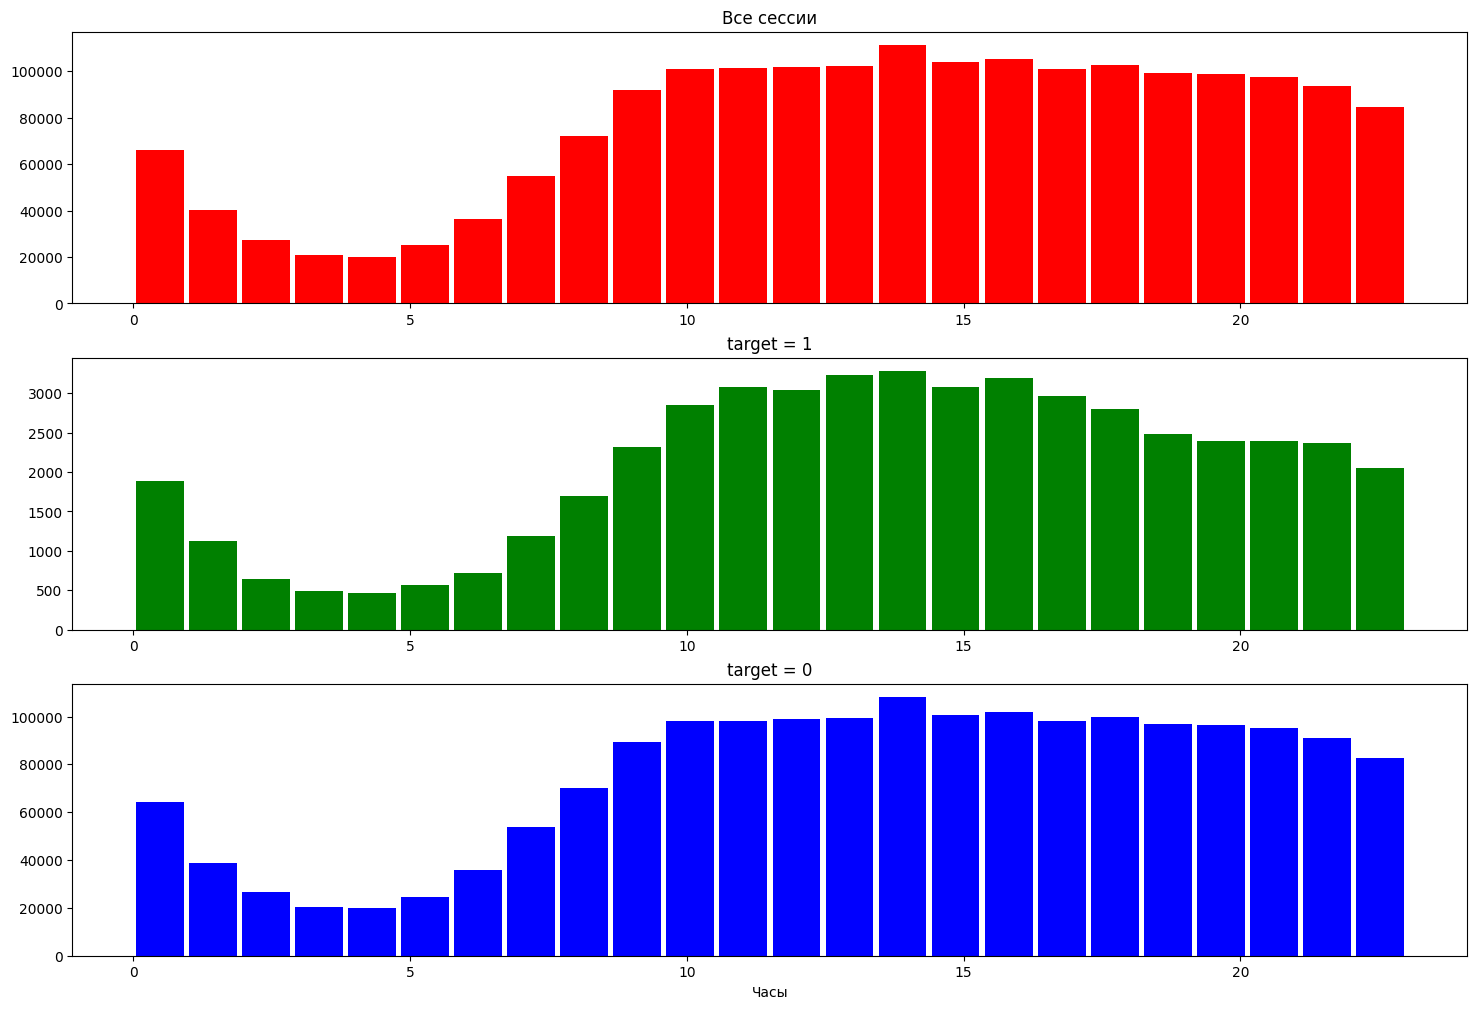

In [19]:
# У нас данные за пол года.
# Это плохо, потому что не ясно как делать предсказание на месяцах, которых нет в тренировочных данных.
# И это может исказить интерпретацию данных, например, если конверсия летом выше, чем зимой 
# и рекламная кампания проводилась летом, то не ясно из-за чего увиличиалсь конверсия (из-за времени года или екламной кампании),
# так как у нас нет данных за несколько лет и даже за один целый год.
# И, если вспомнить постановку задачи (для чего делается модель), то данные по году можно удалить.
# Данные по времени оставим, но сгруппируем по часам

gas['hour'] = gas['visit_date'].dt.hour

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(18, 12))
ax1.hist(gas['visit_date'].dt.hour, bins=24, color='r', rwidth=0.9)
ax1.set_title('Все сессии')
ax2.hist(gas[gas['target'] == 1]['visit_date'].dt.hour, bins=24, color='g', rwidth=0.9)
ax2.set_title('target = 1')
ax3.hist(gas[gas['target'] == 0]['visit_date'].dt.hour, bins=24, color='b', rwidth=0.9)
ax3.set_title('target = 0')
ax3.set_xlabel('Часы');

In [20]:
# удаляем колонку visit_date (остаётся hour)
gas = gas.drop(columns=['visit_date'])

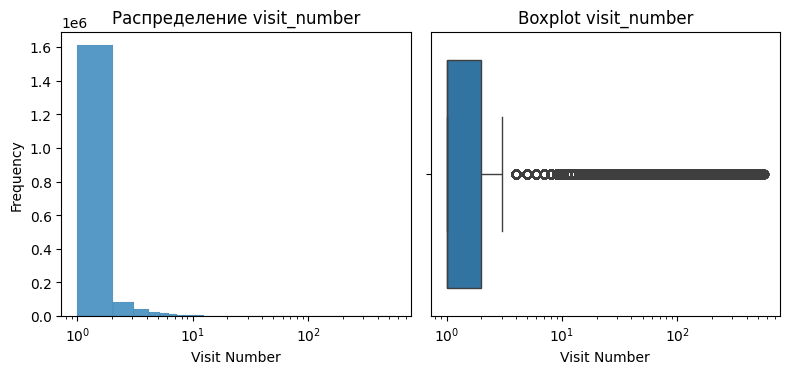

In [21]:
# посмотрим на распределение единственного числового признака visit_number 
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(gas['visit_number'], bins=537, ax=axes[0])
axes[0].set_title('Распределение visit_number')
axes[0].set_xlabel('Visit Number')
axes[0].set_ylabel('Frequency')
axes[0].set_xscale('log')
sns.boxplot(x=gas['visit_number'], ax=axes[1])
axes[1].set_title('Boxplot visit_number')
axes[1].set_xlabel('Visit Number')
axes[1].set_xscale('log')
plt.tight_layout()
plt.show()

In [22]:
print(gas[gas['visit_number'] == 1].shape) # 1376349 из 1860042
print(gas[(gas['visit_number'] >= 2) & (gas['visit_number'] <= 10)].shape) # 431614 из 1860042
print(gas[gas['visit_number'] > 10].shape) # 52079 из 1860042

(1376349, 16)
(431614, 16)
(52079, 16)


In [ ]:
# Это единственный числовой признак, поэтому для лучшей интерпретируемости и исходя из распределения, сделаем его тоже категориальным
# категории: первый визит, от 2 до 10 и больше 10
#gas['visit_number_1'] = (gas['visit_number'] == 1).astype(int)
#gas['visit_number_2_10'] = ((gas['visit_number'] >= 2) & (gas['visit_number'] <= 10)).astype(int)
#gas['visit_number_11'] = (gas['visit_number'] > 10).astype(int)
#gas = gas.drop(columns=['visit_number'])

# Сделаем это после того, как построим аналог матрицы корреляций на основе хи-квадрат-статистики (так как у нас категориальные признаки)

c:\Users\N\AppData\Local\Programs\Python\Python39\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable device_screen_resolution is large: 5039. Are you sure this is not an interval variable? Analysis for pairs of variables including device_screen_resolution can be slow.
  warnings.warn(
c:\Users\N\AppData\Local\Programs\Python\Python39\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable geo_city is large: 2548. Are you sure this is not an interval variable? Analysis for pairs of variables including geo_city can be slow.
  warnings.warn(
c:\Users\N\AppData\Local\Programs\Python\Python39\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable utm_keyword is large: 1220. Are you sure this is not an interval variable? Analysis for pairs of variables including utm_keyword can be slow.
  warnings.warn(


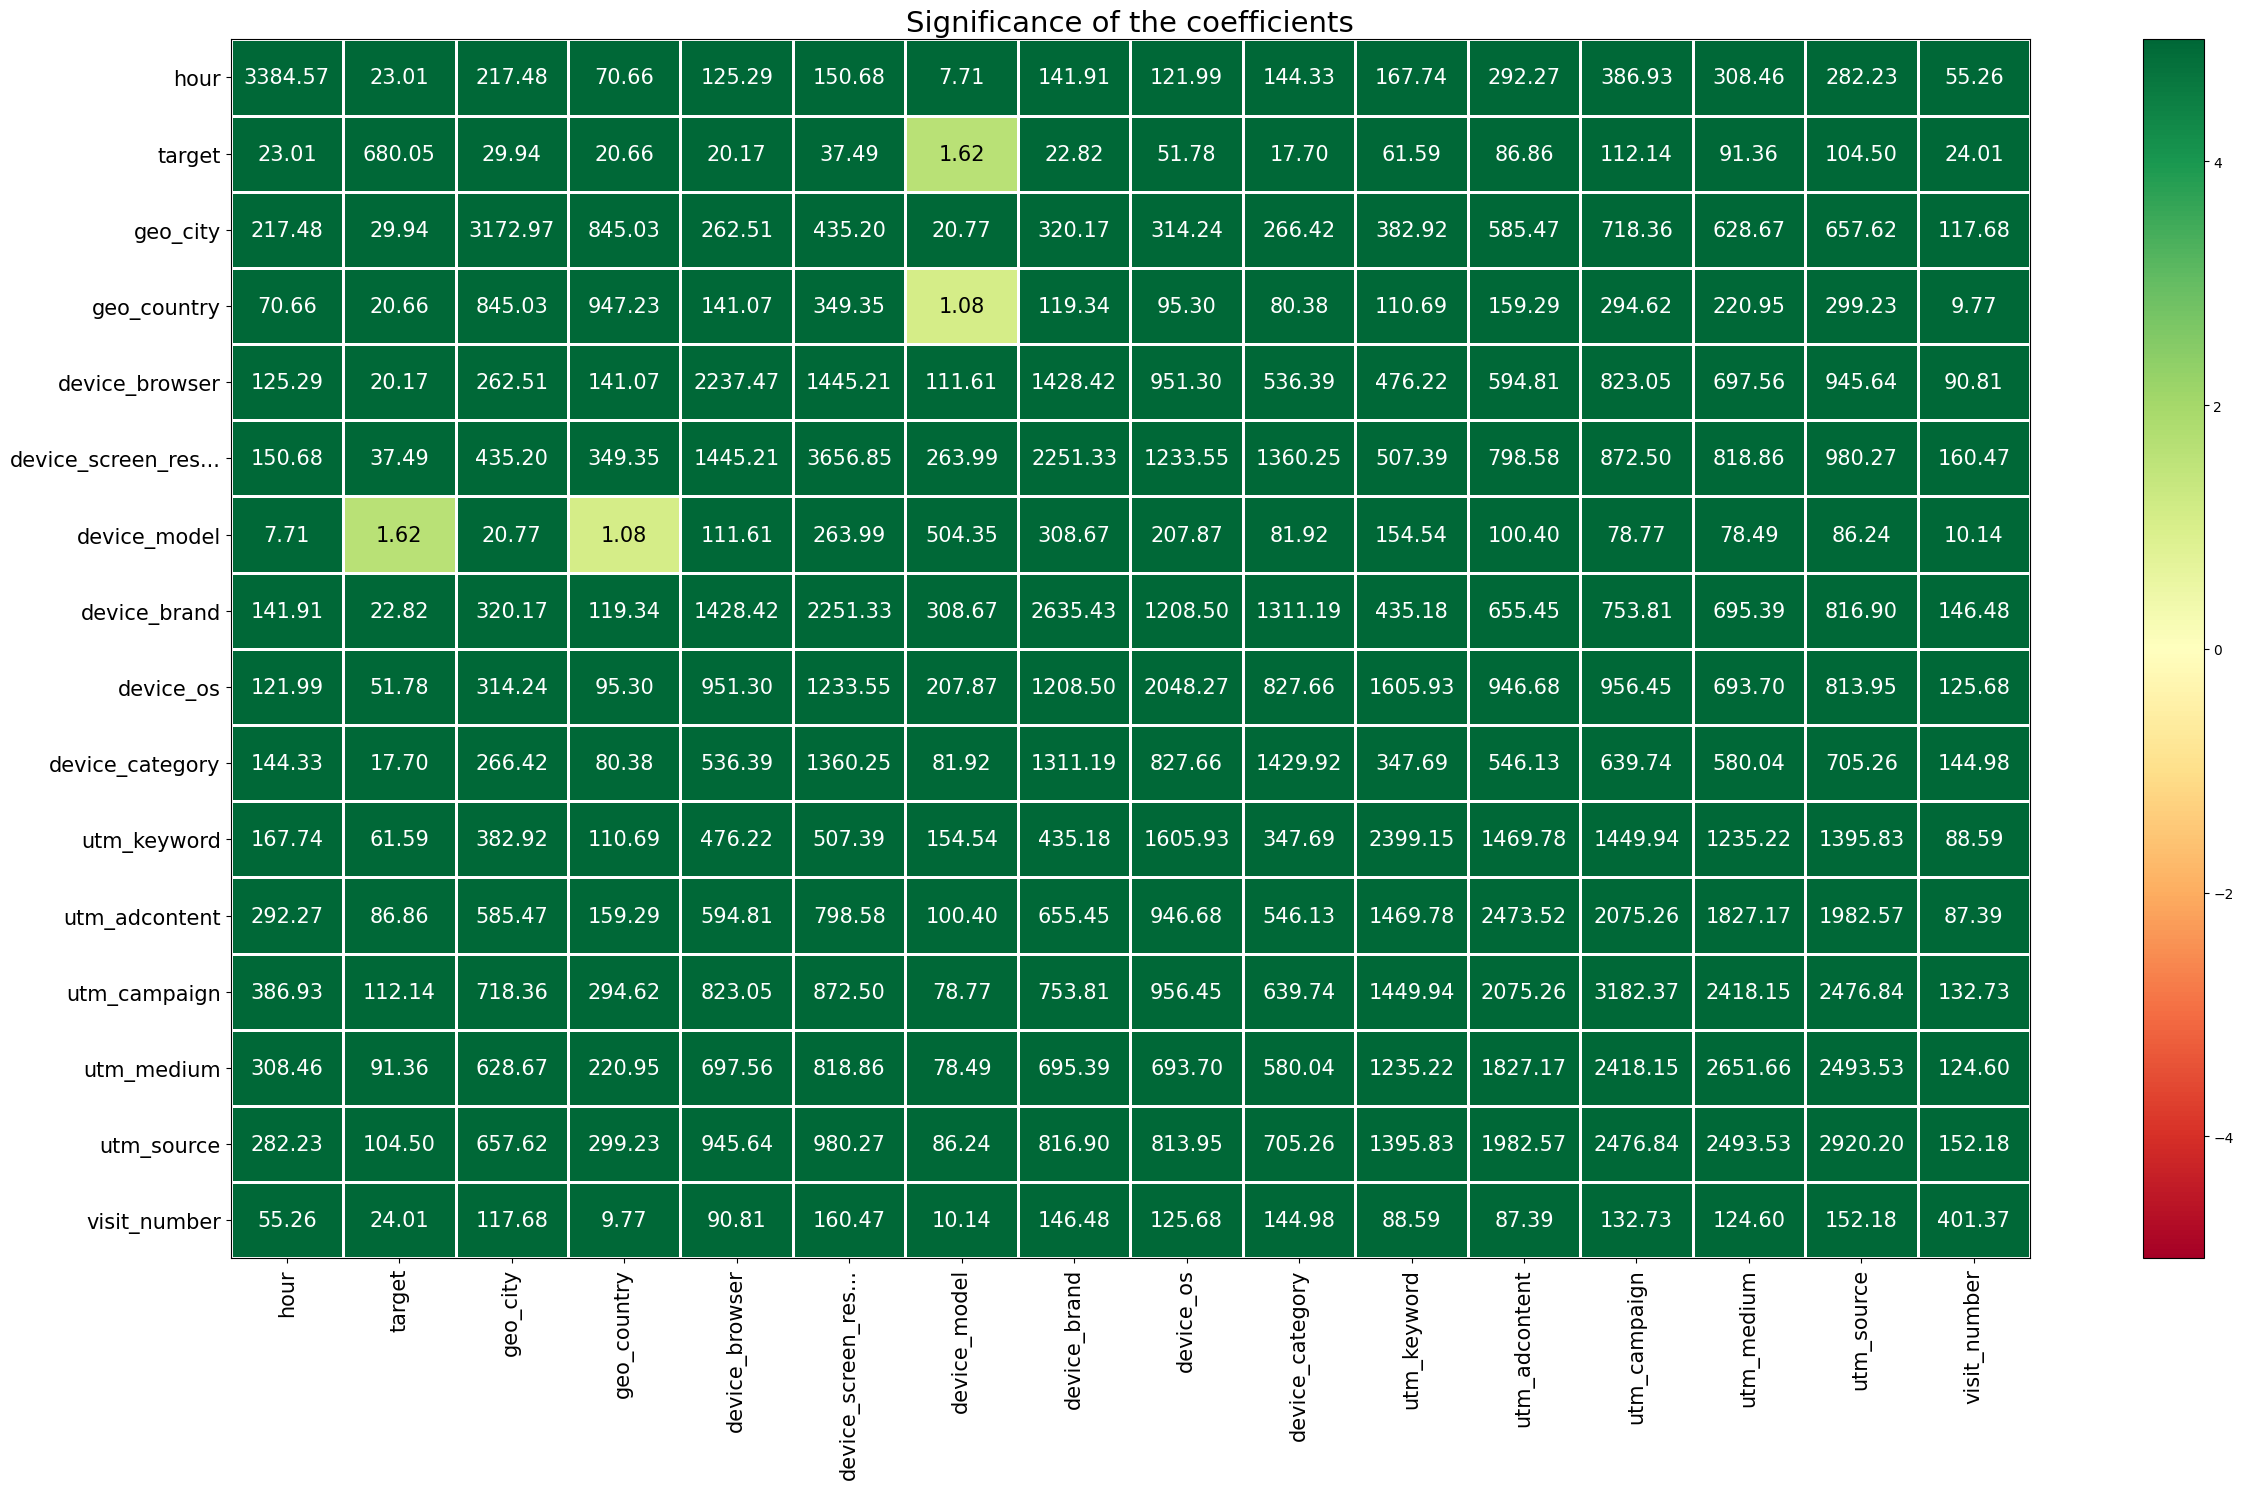

In [62]:
significance_overview = gas.significance_matrix(interval_cols=['visit_number'])
plot_correlation_matrix(significance_overview.fillna(0).values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=-5,
                        vmax=5,
                        title="Significance of the coefficients",
                        usetex=False,
                        fontsize_factor=1.5,
                        figsize=(25, 15))
plt.tight_layout()

In [ ]:
# хорошая статистическая значимость у интересующих нас признаков

c:\Users\N\AppData\Local\Programs\Python\Python39\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable device_screen_resolution is large: 5039. Are you sure this is not an interval variable? Analysis for pairs of variables including device_screen_resolution can be slow.
  warnings.warn(
c:\Users\N\AppData\Local\Programs\Python\Python39\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable geo_city is large: 2548. Are you sure this is not an interval variable? Analysis for pairs of variables including geo_city can be slow.
  warnings.warn(
c:\Users\N\AppData\Local\Programs\Python\Python39\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable utm_keyword is large: 1220. Are you sure this is not an interval variable? Analysis for pairs of variables including utm_keyword can be slow.
  warnings.warn(


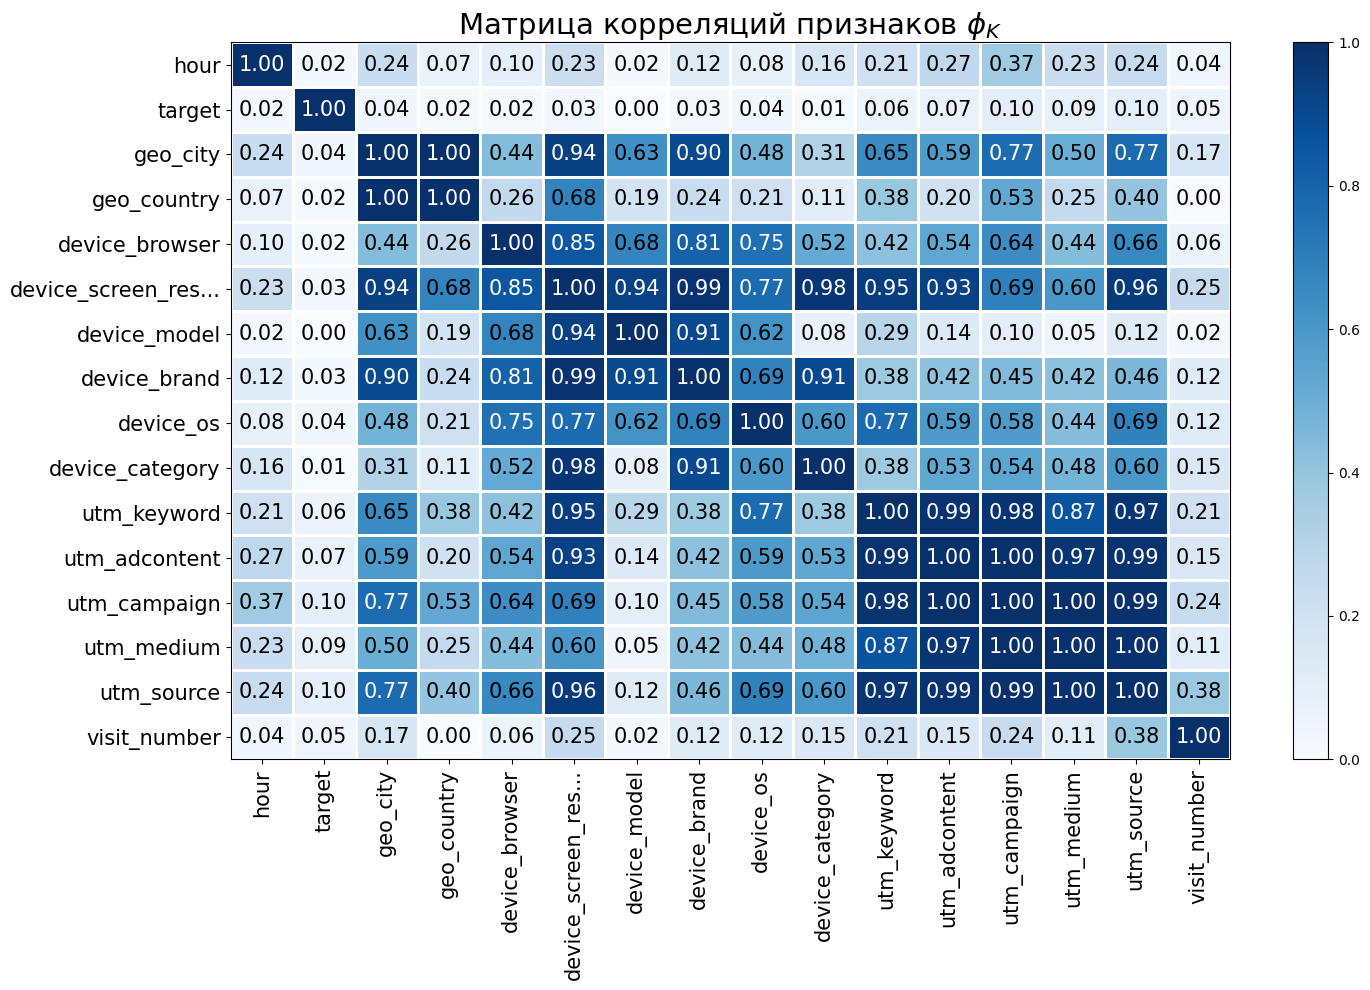

In [61]:
phik_overview = gas.phik_matrix(interval_cols=['visit_number'])

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"Матрица корреляций признаков $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 10))
plt.tight_layout()

In [23]:
# теперь, как писал ранее, сделаем visit_number категориальным признаком
# категории: первый визит, от 2 до 10 и больше 10
gas['visit_number_1'] = (gas['visit_number'] == 1).astype(int)
gas['visit_number_2_10'] = ((gas['visit_number'] >= 2) & (gas['visit_number'] <= 10)).astype(int)
gas['visit_number_11'] = (gas['visit_number'] > 10).astype(int)
gas = gas.drop(columns=['visit_number'])

In [24]:
# очистим переменную gah (она больше не нужна)
del gah

In [26]:
# скопируем gas для применения catBoost (без собственного преобразования категориальных признаков)
gas_cb = gas.copy()

In [27]:
# На основе матрицы корреляций сделаем следующее:
# 1. geo_country удалим, так как вся информация содержится в geo_city.
gas = gas.drop(columns=['geo_country'])
# 2. geo_city оставим, но еще проанализируем ниже отдельно
# 3. device_model удалим, оставим device_brand
gas = gas.drop(columns=['device_model'])
# 4. device_screen_resolution удалим, так как он сильно коррелирует с отальными признаками из блока device, 
# особенно с device_category, что логично. Поэтому тоже удалим.
# хотя, как альтернатива, могли бы оставить или перевести в численный признак (как количество пикселей):
# gas['device_screen_pixels'] = gas['device_screen_resolution'].replace('(not set)', '0x0') # кстати, (not set) в этой колонке был изначально, а не как пропуски.
# gas['device_screen_pixels'] = gas['device_screen_pixels'].apply(lambda x: int(x.split('x')[0]) * int(x.split('x')[1]))
gas = gas.drop(columns=['device_screen_resolution'])
# 5. device_category сильно коррелирует с device_brand, но всё-таки с точки зрения логики оставим оба признака
# 6. Признаки из блока utm сильно коррелируют друг с другом, это помешает интерпретации важности этих признаков между собой.
# Поэтому для модели оставим только признак utm_campaign, как наиболее вариативный из группы utm, не считая utm_keyword, который плохо интерпретируется из-за
# плохого описания этих признаков и их закодированный вид.
gas = gas.drop(columns=['utm_source', 'utm_medium', 'utm_adcontent', 'utm_keyword'])

In [28]:
display(gas.nunique())

utm_campaign          413
device_category         3
device_os              13
device_brand          205
device_browser         57
geo_city             2548
target                  2
hour                   24
visit_number_1          2
visit_number_2_10       2
visit_number_11         2
dtype: int64

In [29]:
# посмотрим на geo_city
print(gas[gas['geo_city'] == 'Moscow'].shape)
print(gas[gas['geo_city'] == 'Saint Petersburg'].shape)

(805329, 11)
(296788, 11)


In [30]:
city_counts = gas['geo_city'].value_counts()
cities_over_10000 = city_counts[city_counts > 10000]
print(cities_over_10000)

geo_city
Moscow              805329
Saint Petersburg    296788
(not set)            78172
Yekaterinburg        35788
Krasnodar            32243
Kazan                29531
Samara               24992
Nizhny Novgorod      22227
Ufa                  21679
Novosibirsk          21568
Krasnoyarsk          16346
Chelyabinsk          15951
Tula                 15814
Voronezh             13908
Rostov-on-Don        13886
Irkutsk              13532
Grozny               12742
Balashikha           12679
Vladivostok          12325
Name: count, dtype: int64


In [31]:
# Заменим все города, для которых меньше 10000 записей на 'others'
cities_to_replace = city_counts[city_counts < 10000].index
gas.loc[gas['geo_city'].isin(cities_to_replace), 'geo_city'] = 'others'

In [32]:
display(gas.nunique())

utm_campaign         413
device_category        3
device_os             13
device_brand         205
device_browser        57
geo_city              20
target                 2
hour                  24
visit_number_1         2
visit_number_2_10      2
visit_number_11        2
dtype: int64

In [33]:
# Теперь селаем one_hot_encoding
def fit_and_save_encoders(df, filename_prefix):
    # Колонки для one-hot encoding
    columns_to_encode = [
        'utm_campaign',
        'device_category',
        'device_os',
        'device_brand',
        'device_browser',
        'hour',
        'geo_city'
    ]
    encoders = {}
    for col in columns_to_encode:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        # Обучение энкодера на текущей колонке
        encoder.fit(df[[col]])
        encoders[col] = encoder
        # Преобразование данных и добавление в DataFrame
        encoded_cols = encoder.get_feature_names_out([col])
        encoded_data = encoder.transform(df[[col]])
        encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df.index)
        # Добавляем закодированные колонки к исходному DataFrame
        df = pd.concat([df, encoded_df], axis=1)
        
    # Удаляем исходные колонки
    df.drop(columns=columns_to_encode, inplace=True)
    
    # Сохраняем энкодеры для последующего использования
    with open(f'{filename_prefix}_encoders.pkl', 'wb') as f:
        pickle.dump(encoders, f)
    
    return df

# эта функция, чтобы готовить новые данные для применения обученной модели
def load_encoders_and_transform(df_new, filename_prefix):
    # Загружаем сохранённые энкодеры
    with open(f'{filename_prefix}_encoders.pkl', 'rb') as f:
        encoders = pickle.load(f)
        
    for col, encoder in encoders.items():
        encoded_cols = encoder.get_feature_names_out([col])
        encoded_data = encoder.transform(df_new[[col]])
        encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df_new.index)
        
        # Добавляем закодированные колонки к новым данным
        df_new = pd.concat([df_new, encoded_df], axis=1)
        
    # Удаляем исходные колонки
    df_new.drop(columns=encoders.keys(), inplace=True)
    
    return df_new

In [34]:
gas = fit_and_save_encoders(gas, 'my_encoder')

In [35]:
# Вот функция для подготовки новых данных:
def prepare(df):
    # 1. удаляем все колонки, кроме utm_campaign, device_category, device_os, device_brand, device_browser, geo_city, visit_number, visit_date, visit_time
    columns_to_keep = ['utm_campaign', 'device_category', 'device_os', 'device_brand', 'device_browser', 'geo_city', 'visit_number', 'visit_date', 'visit_time']

    # 2. заполняем пропуски
    columns_to_exclude = ['visit_date', 'visit_time', 'visit_number'] # список столбцов, которые нужно оставить без изменений
    columns_to_convert = [col for col in df.columns if col not in columns_to_exclude] # список столбцов, которые нужно преобразовать
    for col in columns_to_convert:
        df[col] = df[col].fillna('(not set)')

    # 3. создаём колонку hour
    gas['visit_date'] = pd.to_datetime(gas['visit_date'] + ' ' + gas['visit_time'])
    gas = gas.drop(columns=['visit_time'])
    gas['hour'] = gas['visit_date'].dt.hour
    gas = gas.drop(columns=['visit_date'])

    # 4. кодируем переменную visit_number
    gas['visit_number_1'] = (gas['visit_number'] == 1).astype(int)
    gas['visit_number_2_10'] = ((gas['visit_number'] >= 2) & (gas['visit_number'] <= 10)).astype(int)
    gas['visit_number_11'] = (gas['visit_number'] > 10).astype(int)
    gas = gas.drop(columns=['visit_number'])

    # 5. заменяем geo_city на 'others', если город не из списка 10000-ков:
    allowed_cities = ['Moscow', 'Saint Petersburg', '(not set)', 'Yekaterinburg', 'Krasnodar',
    'Kazan', 'Samara', 'Nizhny Novgorod', 'Ufa', 'Novosibirsk',
    'Krasnoyarsk', 'Chelyabinsk', 'Tula', 'Voronezh', 'Rostov-on-Don',
    'Irkutsk', 'Grozny', 'Balashikha', 'Vladivostok']
    df.loc[~df['geo_city'].isin(allowed_cities), 'geo_city'] = 'others'

    # 6. делаем one_hot_encoding для остальных колонок
    df = load_encoders_and_transform(df, 'my_encoder')

    return df

In [36]:
gas.head(3)

,target,visit_number_1,visit_number_2_10,visit_number_11,utm_campaign_(not set),utm_campaign_AdtHYglxfCpTpwZeTAuW,utm_campaign_AqudXfUnmXWSDWVGYaXr,utm_campaign_BAZCuyHZnaPrMGOMrcCQ,utm_campaign_BHcvLfOaCWvWTykYqHVe,utm_campaign_BHqsCPwtnpaQSryaVXya,...,geo_city_Novosibirsk,geo_city_Rostov-on-Don,geo_city_Saint Petersburg,geo_city_Samara,geo_city_Tula,geo_city_Ufa,geo_city_Vladivostok,geo_city_Voronezh,geo_city_Yekaterinburg,geo_city_others
0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
gas.shape

(1860042, 739)

# Моделирование

Пока не будем заботиться о балансировке классов и о балансировке данных по значениям в колонках.

In [38]:
# Разобьём данные на тренировочную и тестовую выборки
y = gas['target']
X = gas.drop(['target'], axis=1)
# тут используем stratify=y, чтобы сохранить разбалансированность, чтобы случайно не удалить из выборки все положительные классы, которых намного меньше
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y) 


In [115]:
model_lr = LogisticRegression(solver='liblinear', class_weight='balanced', tol=1e-6, random_state=21)
model_lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=21, solver='liblinear',
                   tol=1e-06)

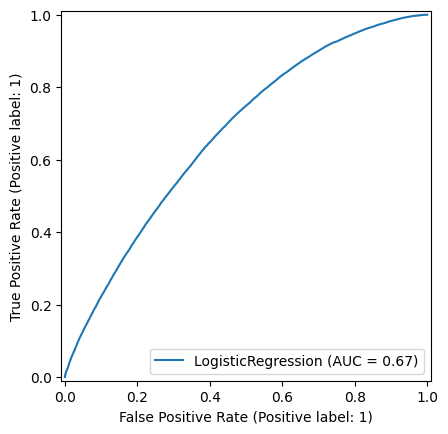

In [116]:
RocCurveDisplay.from_estimator(model_lr, X_train, y_train)
plt.show();

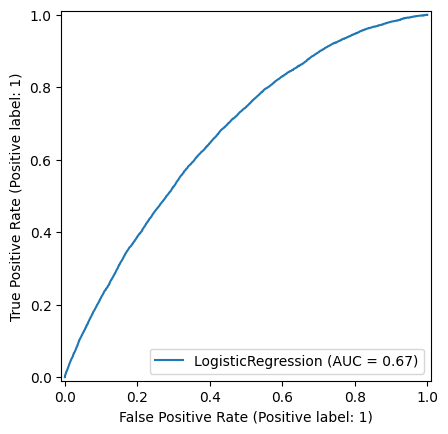

In [117]:
RocCurveDisplay.from_estimator(model_lr, X_test, y_test)
plt.show();

In [ ]:
# Посмотрим на коэффициенты линейно модели, чтобы интерпретировать занимость
columns = gas.columns.tolist()
columns.remove('target')
coef = model_lr.coef_[0]

prefixes = set()
for prefix in ['utm_campaign', 'device_category', 'device_os', 'device_brand', 'device_browser', 'geo_city', 'visit_number', 'hour']:
    prefixes.add(prefix)

results = {}
for prefix in prefixes:
    indices = [i for i, col in enumerate(columns) if col.startswith(prefix)]
    coef_subset = coef[indices]
    min_coef = np.min(coef_subset)
    max_coef = np.max(coef_subset)
    median_coef = np.median(coef_subset)
    results[prefix] = {
        'min': min_coef,
        'max': max_coef,
        'median': median_coef
    }

for prefix, stats in results.items():
    print(f"Префикс: {prefix}")
    print(f"  Min: {stats['min']}")
    print(f"  Max: {stats['max']}")
    print(f"  Median: {stats['median']}\n")

Префикс: utm_campaign
  Min: -4.047504258671476
  Max: 3.998659587774053
  Median: -0.13378314598964763

Префикс: device_os
  Min: -2.0565412450793734
  Max: 0.7554359940169791
  Median: -0.10263268991710785

Префикс: device_brand
  Min: -2.6749757990933802
  Max: 3.985569660664819
  Median: -0.15296583136906403

Префикс: device_browser
  Min: -2.8161517110661873
  Max: 4.160733479551739
  Median: -0.1875644242945245

Префикс: hour
  Min: -0.2853602508978469
  Max: 0.06895453033188513
  Median: -0.07873698386741687

Префикс: device_category
  Min: -0.807417249659244
  Max: -0.6826698228736777
  Median: -0.7385136090845477

Префикс: visit_number
  Min: -0.943599903051552
  Max: -0.6301198884473698
  Median: -0.6548808892200247

Префикс: geo_city
  Min: -0.5759778290341345
  Max: 0.26185597747936584
  Median: -0.10819432374069532



In [ ]:
# то есть видим (по min и max значениям коэффициентов), что самые значимые параметры - это:
# utm_campaign, а точнее весь блок utm
# device_os
# device_brand
# device_browser

In [ ]:
# тут нужно много времени, я пока не стал делать

# попробуем подобрать параметры для линейной модели получше:
model_lr_best = LogisticRegression(penalty='l2', tol=1e-6, random_state=21)
param_grid = {'C': [0.001, 0.01, 1, 10, 100],
            'class_weight': ['balanced', None],
            'solver': ['sag', 'liblinear', 'newton-cholesky']} 
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)
#grid_search = GridSearchCV(estimator=model_lr_best, param_grid=param_grid, cv=stratified_kfold, scoring='roc_auc')
grid_search = RandomizedSearchCV(estimator=model_lr_best, param_distributions=param_grid, cv=stratified_kfold, scoring='roc_auc', random_state=21)
grid_search.fit(X_train, y_train)
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_

In [ ]:

RocCurveDisplay.from_estimator(best_estimator, X_train, y_train)
plt.show();

RocCurveDisplay.from_estimator(best_estimator, X_test, y_test)
plt.show();

In [ ]:
# сравним c catboost на датасете без удаления признаков, чтобы убедиться, что наши преобразования данных ради интерпретируемости не сильно ухудшили точность модели
y_cb = gas_cb['target']
X_cb = gas_cb.drop(['target'], axis=1)
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y_cb, test_size=0.2, random_state=21, stratify=y_cb)

In [50]:
categorical_columns_indices = []
for index, column in enumerate(X_train_cb.columns):
        categorical_columns_indices.append(index) # все признаки категориальные
model_cb = cb.CatBoostClassifier(iterations=100,
                              learning_rate=0.05,
                              loss_function='Logloss',
                              random_state=21,
                              early_stopping_rounds=30,
                              cat_features=categorical_columns_indices
                              )
model_cb.fit(X_train_cb, y_train_cb, verbose=10)

0:	learn: 0.6495238	total: 528ms	remaining: 52.3s
10:	learn: 0.3760505	total: 3.66s	remaining: 29.6s
20:	learn: 0.2499920	total: 7.02s	remaining: 26.4s
30:	learn: 0.1864637	total: 10.5s	remaining: 23.4s
40:	learn: 0.1539589	total: 13.8s	remaining: 19.8s
50:	learn: 0.1375616	total: 17.2s	remaining: 16.5s
60:	learn: 0.1290109	total: 22.3s	remaining: 14.2s
70:	learn: 0.1244489	total: 28.1s	remaining: 11.5s
80:	learn: 0.1219544	total: 34.8s	remaining: 8.15s
90:	learn: 0.1206289	total: 41.4s	remaining: 4.09s
99:	learn: 0.1199539	total: 47.4s	remaining: 0us


In [51]:
roc_auc_score(y_test_cb, model_cb.predict_proba(X_test_cb)[:, 1])

0.6752035643587058

In [58]:
# видим, что метрика близкая - это хорошо.

# теперь посмотрим на важность признаков:
importances = model_cb.feature_importances_
display(pd.DataFrame([importances], columns=X_test_cb.columns))

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,hour,visit_number_1,visit_number_2_10,visit_number_11
0,16.246983,23.744078,21.907997,14.402587,0.411811,2.371533,10.065723,1.636622,0.0,0.0,0.494225,1.100511,0.0,0.319018,3.702583,2.290224,1.306103


In [ ]:
# видим, что данные похожи на интерпретацию линейной модели.

Теперь посмотрим метрику на сбалансированных данных.

In [52]:
gas_target_1 = gas[gas['target'] == 1]
gas_target_0 = gas[gas['target'] == 0]
gas_target_0_sample = gas_target_0.sample(n=len(gas_target_1), random_state=21)
gas_bl = pd.concat([gas_target_1, gas_target_0_sample], ignore_index=True)
gas_bl = gas_bl.sample(frac=1, random_state=42).reset_index(drop=True)

In [59]:
y_bl = gas_bl['target']
X_bl = gas_bl.drop(['target'], axis=1)
X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(X_bl, y_bl, test_size=0.2, random_state=21, stratify=y_bl)

In [61]:
model_lr = LogisticRegression(solver='liblinear', class_weight='balanced', tol=1e-6, random_state=21)
model_lr.fit(X_train_bl, y_train_bl)

LogisticRegression(class_weight='balanced', random_state=21, solver='liblinear',
                   tol=1e-06)

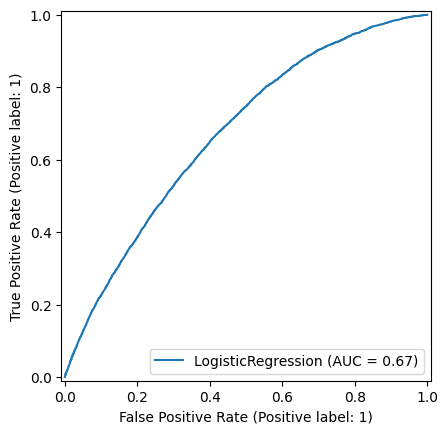

In [62]:
RocCurveDisplay.from_estimator(model_lr, X_test_bl, y_test_bl)
plt.show();

In [ ]:
# метрика получилась близкой, зато данных для обучения значительно меньше и обучение происходит быстрее.
# единственный нюанс: у нас тут 10^5 всего записей из 1.8 * 10^6,
# есть риск, что некоторые колонки будут содержать меньшее количество категорий (т.е one_hot_encoder данные будут иметь константные колонки со значением 0)
# наверное это не так страшно.